In [6]:
import os
import sys
import flopy as fp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyemu
from shutil import copyfile
plt.rcParams['font.size']=12

In [7]:
workspace = "workspace"
model_name = "mf6model"
exe_name="mf6.exe"

nrow = 280
ncol = 240

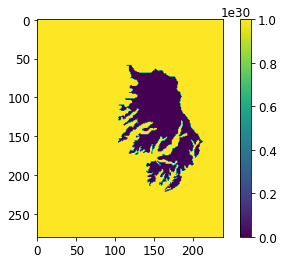

In [8]:
plt.imshow(fp.utils.HeadFile("workspace/{}.hds".format(model_name)).get_data((0,0))[0])
plt.colorbar()

In [9]:
sim = fp.mf6.MFSimulation.load(sim_ws=workspace)
m = sim.get_model(model_name)
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(workspace, "{}.nam".format(model_name)),
        delr=m.dis.delr.array, delc=m.dis.delc.array)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package obs...
    loading package oc...
  loading ims package mf6model...
   could not remove start_datetime


In [10]:
#sr=pyemu.utils.helpers.SpatialReference.set_spatialreference(xul=None, yul=None, xll=None, yll=None, rotation=0.0)

In [11]:
xul, yul = 1098000, 1285000 # Model Origin

dxdy = 50 #grid spacing
delc = np.ones(nrow, dtype=float) * dxdy
delr = np.ones(ncol, dtype=float) * dxdy
rot = 0

sr = pyemu.helpers.SpatialReference(delr=delr, delc=delc, xul=xul, yul=yul, rotation=rot, epsg='3116')
sr

xul:1098000; yul:1285000; rotation:0; proj4_str:+init=epsg:3116; units:meters; lenuni:2; length_multiplier:1.0

In [12]:
file = "heads.csv"
fileout = "workspace/heads.csv"
os.remove(fileout)
copyfile(file, fileout) # copy 

# empty pst from object
template_ws = "template"
pf = pyemu.utils.PstFrom(original_d=workspace, new_d=template_ws,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False)

2021-02-24 15:08:30.381313 starting: opening PstFrom.log for logging
2021-02-24 15:08:30.382312 starting PstFrom process
2021-02-24 15:08:30.383313 starting: setting up dirs
2021-02-24 15:08:30.384312 starting: removing existing new_d 'template'
2021-02-24 15:08:30.411307 finished: removing existing new_d 'template' took: 0:00:00.026995
2021-02-24 15:08:30.411307 starting: copying original_d 'workspace' to new_d 'template'
2021-02-24 15:08:30.459319 finished: copying original_d 'workspace' to new_d 'template' took: 0:00:00.048012
2021-02-24 15:08:30.460320 finished: setting up dirs took: 0:00:00.077007


In [13]:
#add observation
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)

hds_df = pf.add_observations("heads.csv",insfile="heads.csv.ins",index_cols="time",
                use_cols=list(df.columns.values),prefix="hds",obsgp=False)

case = "pest_test"
pf.build_pst("{}.pst".format(case))

2021-02-24 15:08:30.681369 starting: adding observations from tabular output file
2021-02-24 15:08:30.681369 starting: reading list template\heads.csv
2021-02-24 15:08:30.684369 finished: reading list template\heads.csv took: 0:00:00.003000
2021-02-24 15:08:30.684369 starting: building insfile for tabular output file heads.csv
2021-02-24 15:08:30.701373 finished: building insfile for tabular output file heads.csv took: 0:00:00.017004
2021-02-24 15:08:30.701373 starting: adding observation from instruction file 'template\heads.csv.ins'
2021-02-24 15:08:30.710376 finished: adding observation from instruction file 'template\heads.csv.ins' took: 0:00:00.009003
2021-02-24 15:08:30.711376 finished: adding observations from tabular output file took: 0:00:00.030007
noptmax:30, npar_adj:0, nnz_obs:33


spatial variogram


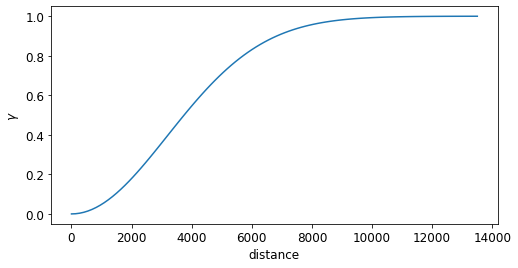

In [14]:
ppspace1=30
a = ppspace1*3.0*50
v = pyemu.geostats.GauVario(contribution=1.0,a=a)
grid_gs1 = pyemu.geostats.GeoStruct(variograms=v, transform='log')

fig = plt.figure(figsize=(8,4))
grid_gs1.plot()
print("spatial variogram")

spatial variogram


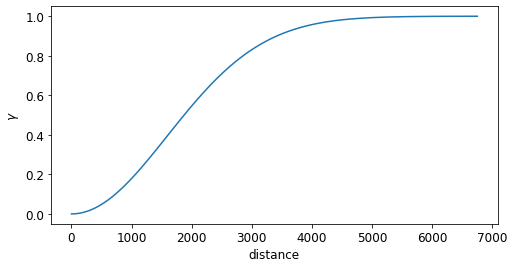

In [15]:
ppspace2=15
a = ppspace2*3.0*50
v = pyemu.geostats.GauVario(contribution=1.0,a=a)
grid_gs2 = pyemu.geostats.GeoStruct(variograms=v, transform='log')

fig = plt.figure(figsize=(8,4))
grid_gs2.plot()
print("spatial variogram")

In [16]:
# set an homogeneous k array (as initial value)
# k = 1e-4*np.ones([nrow,ncol])
# filnm = "k.txt"
# np.savetxt(os.path.join(template_ws,filnm),k)

In [17]:
# Model domain in txt file because the code for some reason is not respecting my m.dis.idomain in the pilot point section
# maxsize to check these matrices very well!
np.set_printoptions(threshold=sys.maxsize)

ib0=np.loadtxt(os.path.join(workspace,"mf6model.dis_idomain_layer0.txt"))
ib1=np.loadtxt(os.path.join(workspace,"mf6model.dis_idomain_layer1.txt"))
ib2=np.loadtxt(os.path.join(workspace,"mf6model.dis_idomain_layer2.txt"))
ib3=np.loadtxt(os.path.join(workspace,"mf6model.dis_idomain_layer3.txt"))

ib=[ib0,ib1,ib2,ib3]

# To make sure only greater than zero values are being considered in the pilot point automated placement for all layers
nlay=4
for i in range(0,nlay):
    ib[i][ib[i]==-1]=0

In [18]:
#Horizontal conductivity for the 4 layers
#layer1

pf.add_parameters(filenames="hk0.txt",par_type="constant",
                   par_name_base="kp0",pargp="hp1", zone_array=ib[0], spatial_reference=sr,
                   upper_bound=10.,lower_bound=0.1, ult_ubound=1.1921e-3,ult_lbound=1.1574e-8)

#layer2
pf.add_parameters(filenames="hk1.txt",par_type="pilotpoint",pp_space=ppspace2,
                   par_name_base="kp1",pargp="hp2", zone_array=ib[1], spatial_reference=sr,
                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs2, ult_ubound=1.1921e-3,ult_lbound=1.1921e-5)
#layer3
pf.add_parameters(filenames="hk2.txt",par_type="pilotpoint",pp_space=ppspace2,
                   par_name_base="kp2",pargp="hp3", zone_array=ib[2], spatial_reference=sr,
                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs2, ult_ubound=1.1574e-6,ult_lbound=1.1574e-8)

#layer4
pf.add_parameters(filenames="hk3.txt",par_type="pilotpoint",pp_space=ppspace1,
                   par_name_base="kp3",pargp="hp4", zone_array=ib[3], spatial_reference=sr,
                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs1, ult_ubound=4.167e-4,ult_lbound=4.167e-6)

#Vertical conductivity for the 4 layers
#layer1

pf.add_parameters(filenames="vk0.txt",par_type="constant",
                  par_name_base="kp0",pargp="vp1", zone_array=ib[0], spatial_reference=sr,
                  upper_bound=10.,lower_bound=0.1, ult_ubound=2.1991e-4,ult_lbound=1.0417e-8)

#layer2
pf.add_parameters(filenames="vk1.txt",par_type="pilotpoint",pp_space=ppspace2,
                  par_name_base="kp1",pargp="vp2", zone_array=ib[1], spatial_reference=sr,
                  upper_bound=10.,lower_bound=0.1,geostruct=grid_gs2, ult_ubound=2.1991e-4,ult_lbound=2.1991e-6)
#layer3
pf.add_parameters(filenames="vk2.txt",par_type="pilotpoint",pp_space=ppspace2,
                   par_name_base="kp2",pargp="vp3", zone_array=ib[2], spatial_reference=sr,
                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs2, ult_ubound=1.0417e-6,ult_lbound=1.0417e-8)
#layer4
pf.add_parameters(filenames="vk3.txt",par_type="pilotpoint",pp_space=ppspace1,
                   par_name_base="kp3",pargp="vp4", zone_array=ib[3], spatial_reference=sr,
                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs1, ult_ubound=1.736e-5,ult_lbound=1.736e-7)



2021-02-24 15:08:32.472622 starting: adding constant type multiplier style parameters for file(s) ['hk0.txt']
2021-02-24 15:08:32.472622 starting: loading array template\hk0.txt
2021-02-24 15:08:32.517631 finished: loading array template\hk0.txt took: 0:00:00.045009
2021-02-24 15:08:32.517631 loaded array 'hk0.txt' of shape (280, 240)
2021-02-24 15:08:32.579645 starting: writing array-based template file 'kp0_inst0_constant.csv.tpl'
2021-02-24 15:08:32.580646 starting: writing template file kp0_inst0_constant.csv.tpl for ['kp0_inst:0']
2021-02-24 15:08:32.716676 finished: writing template file kp0_inst0_constant.csv.tpl for ['kp0_inst:0'] took: 0:00:00.136030
2021-02-24 15:08:32.716676 finished: writing array-based template file 'kp0_inst0_constant.csv.tpl' took: 0:00:00.137031
2021-02-24 15:08:32.729679 finished: adding constant type multiplier style parameters for file(s) ['hk0.txt'] took: 0:00:00.257057
2021-02-24 15:08:32.730678 starting: adding pilotpoint type multiplier style par

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


took 29.175483 seconds
2021-02-24 15:09:02.506187 finished: calculating factors for pargp=kp1_inst:0 took: 0:00:29.594079
2021-02-24 15:09:02.506187 starting: writing array-based template file 'kp1_inst0pp.dat.tpl'
2021-02-24 15:09:02.511188 finished: adding pilotpoint type multiplier style parameters for file(s) ['hk1.txt'] took: 0:00:29.780510
2021-02-24 15:09:02.522190 starting: adding pilotpoint type multiplier style parameters for file(s) ['hk2.txt']
2021-02-24 15:09:02.522190 starting: loading array template\hk2.txt
2021-02-24 15:09:02.566200 finished: loading array template\hk2.txt took: 0:00:00.044010
2021-02-24 15:09:02.566200 loaded array 'hk2.txt' of shape (280, 240)
2021-02-24 15:09:02.632215 starting: writing array-based template file 'kp2_inst0_pilotpoint.csv.tpl'
2021-02-24 15:09:02.632215 starting: setting up pilot point parameters
2021-02-24 15:09:02.701231 37 pilot point parameters created
2021-02-24 15:09:02.701231 pilot point 'pargp':kp2_inst:0
2021-02-24 15:09:02.7

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


took 49.07907 seconds
2021-02-24 15:09:54.096915 finished: calculating factors for pargp=kp3_inst:0 took: 0:00:51.182555
2021-02-24 15:09:54.096915 starting: writing array-based template file 'kp3_inst0pp.dat.tpl'
2021-02-24 15:09:54.102916 finished: adding pilotpoint type multiplier style parameters for file(s) ['hk3.txt'] took: 0:00:51.387682
2021-02-24 15:09:54.146926 starting: adding constant type multiplier style parameters for file(s) ['vk0.txt']
2021-02-24 15:09:54.146926 starting: loading array template\vk0.txt
2021-02-24 15:09:54.190936 finished: loading array template\vk0.txt took: 0:00:00.044010
2021-02-24 15:09:54.190936 loaded array 'vk0.txt' of shape (280, 240)
2021-02-24 15:09:54.253950 starting: writing array-based template file 'kp0_inst1_constant.csv.tpl'
2021-02-24 15:09:54.254951 starting: writing template file kp0_inst1_constant.csv.tpl for ['kp0_inst:1']
2021-02-24 15:09:54.390981 finished: writing template file kp0_inst1_constant.csv.tpl for ['kp0_inst:1'] took: 

In [19]:
# add run model command
pf.mod_sys_cmds.append("..\mf6")
pf.build_pst("{}.pst".format(case))

noptmax:30, npar_adj:246, nnz_obs:33
2021-02-24 15:09:55.136529 forward_run line:pyemu.os_utils.run(r'..\mf6')



In [20]:
#Rewrite ins file because Pyemu isn't smart enough

file = "template/heads.csv.ins"
fileout = "template/heads2.csv.ins"
with open(file) as f:
    with open(fileout,"w") as fout:
        for i,line in enumerate(f):
            if i < 2:
                fout.write(line)
            if i > 1:
                for o,split in enumerate(line.split("w")):
                    if o == 1:
                        fout.write("~,~")
                    fout.write(split)
                        

copyfile(fileout, file) # copy 
os.remove(fileout) # delete tmp file

noptmax:30, npar_adj:246, nnz_obs:33
2021-02-24 15:09:55.295566 WARNING: sys_cmd 'pyemu.os_utils.run(r'..\mf6')
' already in sys cmds, skipping...
2021-02-24 15:09:55.307569 starting: building prior covariance matrix
2021-02-24 15:09:55.352578 saving prior covariance matrix to file template\pest_test.prior.cov
2021-02-24 15:09:55.384585 finished: building prior covariance matrix took: 0:00:00.077016


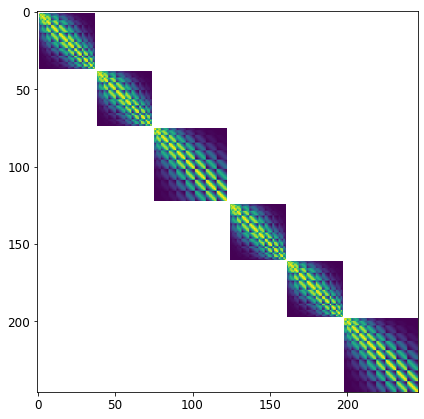

In [21]:
pst = pf.build_pst("{}.pst".format(case))
cov = pf.build_prior()
x = cov.x.copy()
x[x==0.0] = np.NaN
fig,ax = plt.subplots(1,1,figsize=(7,7))
g = ax.imshow(x)

In [22]:
t_d = "template"
m_d = "master_glm"

pst.control_data.noptmax = 0 # just a run
pst.write(os.path.join(t_d,"{}.pst".format(case)))

noptmax:0, npar_adj:246, nnz_obs:33


In [23]:
# calculate
n = 3 #select number of workers
pyemu.os_utils.start_workers(t_d,"../pestpp-glm.exe","{}.pst".format(case),num_workers=n,worker_root=".",master_dir=m_d)

In [ ]:
pst.control_data.noptmax = -1 # FOR JACOBIAN
pst.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.start_workers(t_d,"../pestpp-glm.exe","{}.pst".format(case),num_workers=n,worker_root=".",master_dir=m_d)

noptmax:-1, npar_adj:246, nnz_obs:33


In [ ]:
t_d ="master_glm"
case="pest_test"
pst = pyemu.Pst(os.path.join(t_d,"{}.pst".format(case)))
pst.write_par_summary_table(filename="none")

In [21]:
pst.control_data.noptmax = 15
pst.control_data.pestmode = "regularization"

pst.pestpp_options["n_iter_base"] = 1 
pst.pestpp_options["n_iter_super"] = 4 
# pst.pestpp_options["glm_num_reals"] = 300 
#
pst.pestpp_options["parcov"] = "{}.prior.cov".format(case) 
pst.pestpp_options["base_jacobian"] = "{}.jcb".format(case) 
pst.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.helpers.zero_order_tikhonov(pst)

noptmax:15, npar_adj:246, nnz_obs:33


In [22]:
m_d = "master_glm_run"
pyemu.os_utils.start_workers(t_d,"../pestpp-glm","{}.pst".format(case),num_workers=n,worker_root=".",
                           master_dir=m_d)

[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

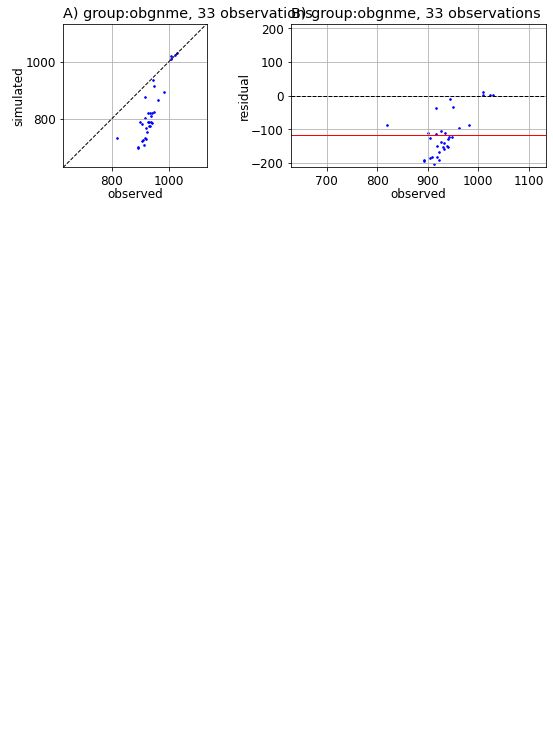

In [27]:
pst_a = pyemu.Pst(os.path.join(m_d,"{}.pst".format(case)))
pst_a.plot(kind='1to1')

In [24]:
# df = df=pd.read_csv(os.path.join(m_d,"{}.post.obsen.csv".format(case)),index_col=0)
# oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)
# ax = oe.phi_vector.hist()

In [29]:
dfp = df=pd.read_csv(os.path.join(m_d,"{}.par.usum.csv".format(case)),index_col=0)
10**dfp["post_mean"]

name
MULTIPLIER_CONST_KP0_INST:0    1.000000
KP1_INST:0_I:67_J:127          1.000000
KP1_INST:0_I:67_J:157          1.000000
KP1_INST:0_I:82_J:142          1.000000
KP1_INST:0_I:82_J:157          2.457605
                                 ...   
KP3_INST:1_I:255_J:75          1.000000
KP3_INST:1_I:255_J:105         1.000000
KP3_INST:1_I:255_J:135         1.000000
KP3_INST:1_I:255_J:165         2.457605
KP3_INST:1_I:255_J:195         1.000000
Name: post_mean, Length: 246, dtype: float64

(array([ 25.,   1., 149.,   1.,   0.,   0.,   0.,  46.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,  23.]),
 array([ 0.1 ,  0.43,  0.76,  1.09,  1.42,  1.75,  2.08,  2.41,  2.74,
         3.07,  3.4 ,  3.73,  4.06,  4.39,  4.72,  5.05,  5.38,  5.71,
         6.04,  6.37,  6.7 ,  7.03,  7.36,  7.69,  8.02,  8.35,  8.68,
         9.01,  9.34,  9.67, 10.  ]),
 <BarContainer object of 30 artists>)

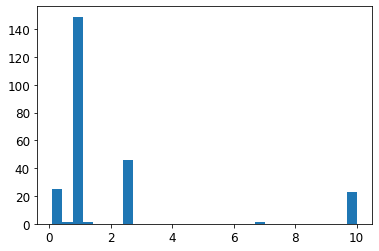

In [30]:
plt.hist(10**dfp["post_mean"],bins=30)

In [31]:
pst.parameter_data.parval1 = 10**dfp["post_mean"].values
pst.control_data.noptmax = 0 # one run with optimal parameters

pst.write(os.path.join(t_d,"{}.pst".format(case)))

pyemu.os_utils.run("..\pestpp-glm.exe {}".format(case),cwd=t_d)

noptmax:0, npar_adj:246, nnz_obs:33


Text(0.5, 1.0, 'k after inversion')

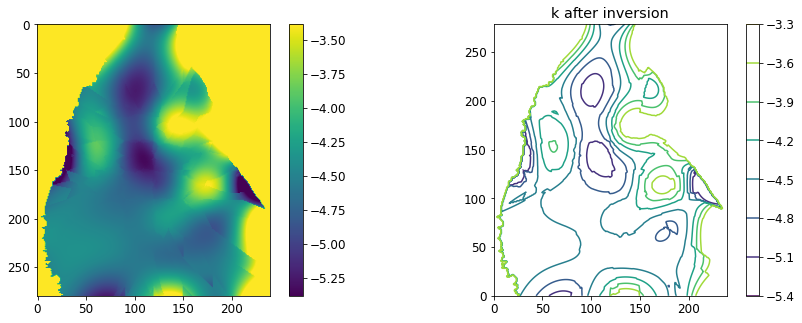

In [29]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
t_d ="master_glm"
# inversion
g= ax[0].imshow(np.log10(np.loadtxt(os.path.join(t_d,"hk3.txt"))))
plt.colorbar(g,ax=ax[0])
plt.title("k after inversion")

a=ax[1].contour(np.flipud(np.log10(np.loadtxt(os.path.join(t_d,"hk3.txt")))))
ax[1].set_aspect("equal")
plt.colorbar(a,ax=ax[1])
plt.title("k after inversion")

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

# inversion
g= ax[0].imshow(np.log10(np.loadtxt(os.path.join("workspace","hk2.txt"))))
plt.colorbar(g,ax=ax[0])
plt.title("k before inversion")

a=ax[1].contour(np.flipud(np.log10(np.loadtxt(os.path.join("workspace","hk0.txt")))))
ax[1].set_aspect("equal")
plt.colorbar(a,ax=ax[1])
plt.title("k before inversion")

579921.8097000001 {'obgnme': 579921.8097000001} {'obgnme': 1.0}


[None,
 None,
 <AxesSubplot:>,
 <AxesSubplot:xlabel='model runs', ylabel='$\\phi$'>]

<Figure size 576x756 with 0 Axes>

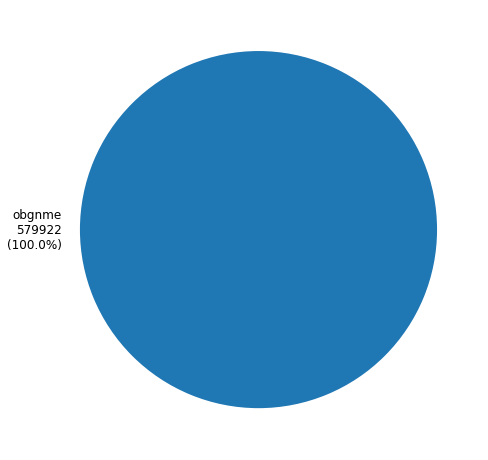

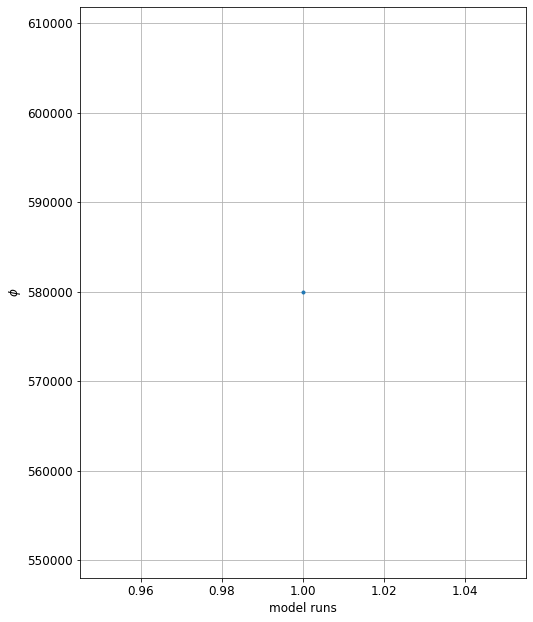

In [30]:
pst_a.plot()